This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

## DeepDream

### Implementing DeepDream in Keras

**Fetching the test image**

440742/440742 [==============================] - 1s 2us/step


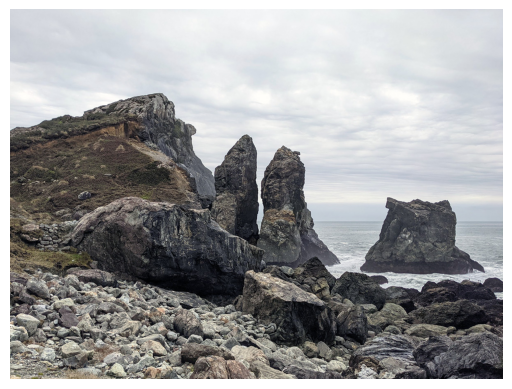

In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt

base_image_path = keras.utils.get_file(
    "coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg")

plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

**Instantiating a pretrained `InceptionV3` model**

In [2]:
from tensorflow.keras.applications import inception_v3
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

2023-11-17 10:42:55.596083: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-17 10:42:55.596246: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

87910968/87910968 [==============================] - 9s 0us/step


**Configuring the contribution of each layer to the DeepDream loss**

In [3]:
layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

**The DeepDream loss**

In [4]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    return loss

**The DeepDream gradient ascent process**

In [5]:
import tensorflow as tf

@tf.function
def gradient_ascent_step(image, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return loss, image


def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print(f"... Loss value at step {i}: {loss:.2f}")
    return image

In [6]:
step = 20.
num_octave = 3
octave_scale = 1.4
iterations = 30
max_loss = 15.

**Image processing utilities**

In [7]:
import numpy as np

def preprocess_image(image_path):
    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img /= 2.0
    img += 0.5
    img *= 255.
    img = np.clip(img, 0, 255).astype("uint8")
    return img

**Running gradient ascent over multiple successive "octaves"**

In [8]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
    print(f"Processing octave {i} with shape {shape}")
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.utils.save_img("dream.png", deprocess_image(img.numpy()))

Processing octave 0 with shape (459, 612)


2023-11-17 10:43:12.151186: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-17 10:43:12.151851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


... Loss value at step 0: 0.80
... Loss value at step 1: 1.07
... Loss value at step 2: 1.44
... Loss value at step 3: 1.82
... Loss value at step 4: 2.15
... Loss value at step 5: 2.48
... Loss value at step 6: 2.83
... Loss value at step 7: 3.20
... Loss value at step 8: 3.51
... Loss value at step 9: 3.89
... Loss value at step 10: 4.21
... Loss value at step 11: 4.58
... Loss value at step 12: 4.92
... Loss value at step 13: 5.26
... Loss value at step 14: 5.62
... Loss value at step 15: 5.97
... Loss value at step 16: 6.27
... Loss value at step 17: 6.65
... Loss value at step 18: 6.91
... Loss value at step 19: 7.30
... Loss value at step 20: 7.65
... Loss value at step 21: 7.91
... Loss value at step 22: 8.26
... Loss value at step 23: 8.59
... Loss value at step 24: 8.81
... Loss value at step 25: 9.11
... Loss value at step 26: 9.36
... Loss value at step 27: 9.68
... Loss value at step 28: 9.94
... Loss value at step 29: 10.19
Processing octave 1 with shape (642, 857)


2023-11-17 10:43:17.017443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


... Loss value at step 0: 1.59
... Loss value at step 1: 2.62
... Loss value at step 2: 3.41
... Loss value at step 3: 4.03
... Loss value at step 4: 4.55
... Loss value at step 5: 5.04
... Loss value at step 6: 5.54
... Loss value at step 7: 5.96
... Loss value at step 8: 6.43
... Loss value at step 9: 6.81
... Loss value at step 10: 7.16
... Loss value at step 11: 7.54
... Loss value at step 12: 7.84
... Loss value at step 13: 8.21
... Loss value at step 14: 8.56
... Loss value at step 15: 8.91
... Loss value at step 16: 9.14
... Loss value at step 17: 9.60
... Loss value at step 18: 9.74
... Loss value at step 19: 10.18
... Loss value at step 20: 10.35
... Loss value at step 21: 10.82
... Loss value at step 22: 11.13
... Loss value at step 23: 11.35
... Loss value at step 24: 11.97
... Loss value at step 25: 12.04
... Loss value at step 26: 12.61
... Loss value at step 27: 12.69
... Loss value at step 28: 13.29
... Loss value at step 29: 13.27
Processing octave 2 with shape (900, 12

2023-11-17 10:43:21.597759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


... Loss value at step 0: 1.39
... Loss value at step 1: 2.16
... Loss value at step 2: 2.81
... Loss value at step 3: 3.33
... Loss value at step 4: 3.81
... Loss value at step 5: 4.21
... Loss value at step 6: 4.70
... Loss value at step 7: 5.15
... Loss value at step 8: 5.56
... Loss value at step 9: 5.99
... Loss value at step 10: 6.25
... Loss value at step 11: 6.82
... Loss value at step 12: 7.09
... Loss value at step 13: 7.65
... Loss value at step 14: 7.82
... Loss value at step 15: 8.47
... Loss value at step 16: 8.64
... Loss value at step 17: 9.09
... Loss value at step 18: 9.31
... Loss value at step 19: 9.86
... Loss value at step 20: 10.10
... Loss value at step 21: 10.62
... Loss value at step 22: 10.78
... Loss value at step 23: 11.26
... Loss value at step 24: 11.55
... Loss value at step 25: 11.92
... Loss value at step 26: 12.38
... Loss value at step 27: 12.73
... Loss value at step 28: 13.23
... Loss value at step 29: 13.36


## Neural style transfer

### The content loss

### The style loss

### Neural style transfer in Keras

**Getting the style and content images**

In [9]:
from tensorflow import keras

base_image_path = keras.utils.get_file(
    "sf.jpg", origin="https://img-datasets.s3.amazonaws.com/sf.jpg")
style_reference_image_path = keras.utils.get_file(
    "starry_night.jpg", origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")

original_width, original_height = keras.utils.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

943128/943128 [==============================] - 1s 1us/step


**Auxiliary functions**

In [10]:
import numpy as np

def preprocess_image(image_path):
    img = keras.utils.load_img(
        image_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

**Using a pretrained VGG19 model to create a feature extractor**

In [11]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 [==============================] - 7s 0us/step


**Content loss**

In [12]:
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))

**Style loss**

In [13]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

**Total variation loss**

In [14]:
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
    )
    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

**Defining the final loss that you'll minimize**

In [15]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv2"
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(
          style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value

    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

**Setting up the gradient-descent process**

In [16]:
import tensorflow as tf

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        keras.utils.save_img(fname, img)

2023-11-17 10:43:42.383469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Iteration 100: loss=8138.08
Iteration 200: loss=6653.08
Iteration 300: loss=6063.16
Iteration 400: loss=5742.66
Iteration 500: loss=5536.25
Iteration 600: loss=5390.38
Iteration 700: loss=5281.03
Iteration 800: loss=5195.46
Iteration 900: loss=5126.28
Iteration 1000: loss=5069.20
Iteration 1100: loss=5021.19
Iteration 1200: loss=4980.45
Iteration 1300: loss=4945.20
Iteration 1400: loss=4914.38
Iteration 1500: loss=4887.30
Iteration 1600: loss=4863.28
Iteration 1700: loss=4841.80
Iteration 1800: loss=4822.55
Iteration 1900: loss=4805.21
Iteration 2000: loss=4789.48
Iteration 2100: loss=4775.08
Iteration 2200: loss=4761.94
Iteration 2300: loss=4749.92
Iteration 2400: loss=4738.81
Iteration 2500: loss=4728.58
Iteration 2600: loss=4719.12
Iteration 2700: loss=4710.35
Iteration 2800: loss=4702.19
Iteration 2900: loss=4694.62
Iteration 3000: loss=4687.57
Iteration 3100: loss=4680.98
Iteration 3200: loss=4674.84
Iteration 3300: loss=4669.09
Iteration 3400: loss=4663.70
Iteration 3500: loss=46

### Additional Experiment

26576/26576 [==============================] - 0s 0us/step


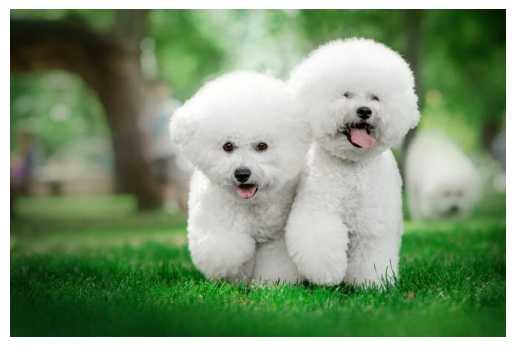

In [21]:
base_image_path = keras.utils.get_file(
    "bichon_frise.jpg", 
    origin="https://img3.daumcdn.net/thumb/R658x0.q70/?fname=https://t1.daumcdn.net/news/202303/31/bemypet/20230331153031288wnaq.jpg")


plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

In [22]:
from tensorflow.keras.applications import inception_v3
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

def compute_loss(input_image):
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    return loss

import tensorflow as tf

@tf.function
def gradient_ascent_step(image, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return loss, image


def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print(f"... Loss value at step {i}: {loss:.2f}")
    return image

step = 20.
num_octave = 3
octave_scale = 1.4
iterations = 30
max_loss = 15.

import numpy as np

def preprocess_image(image_path):
    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img /= 2.0
    img += 0.5
    img *= 255.
    img = np.clip(img, 0, 255).astype("uint8")
    return img

original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
    print(f"Processing octave {i} with shape {shape}")
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.utils.save_img("dream1.png", deprocess_image(img.numpy()))


Processing octave 0 with shape (221, 335)


2023-11-20 09:57:52.116056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


... Loss value at step 0: 1.43
... Loss value at step 1: 1.52
... Loss value at step 2: 1.97
... Loss value at step 3: 2.52
... Loss value at step 4: 3.08
... Loss value at step 5: 3.66
... Loss value at step 6: 4.24
... Loss value at step 7: 4.73
... Loss value at step 8: 5.42
... Loss value at step 9: 5.84
... Loss value at step 10: 6.49
... Loss value at step 11: 7.03
... Loss value at step 12: 7.54
... Loss value at step 13: 8.14
... Loss value at step 14: 8.68
... Loss value at step 15: 9.33
... Loss value at step 16: 10.00
... Loss value at step 17: 10.75
... Loss value at step 18: 11.32
... Loss value at step 19: 12.09
... Loss value at step 20: 12.34
... Loss value at step 21: 13.04
... Loss value at step 22: 13.68
... Loss value at step 23: 14.57
Processing octave 1 with shape (310, 470)


2023-11-20 09:57:56.434806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


... Loss value at step 0: 1.87
... Loss value at step 1: 3.46
... Loss value at step 2: 5.56
... Loss value at step 3: 8.38
... Loss value at step 4: 13.03
Processing octave 2 with shape (435, 658)


2023-11-20 09:57:59.063069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


... Loss value at step 0: 5.84
... Loss value at step 1: 11.42


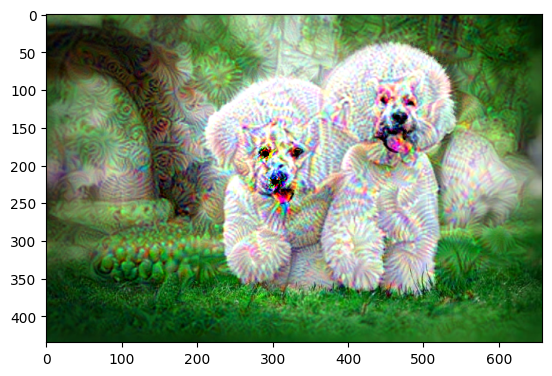

In [24]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread("dream1.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()